In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits

from skimage.util import view_as_windows

In [9]:
PATH_DATA = '/Volumes/ES-LaCie/Documents/MATLAS'

In [10]:
galaxies = np.loadtxt(f'{PATH_DATA}/galaxies.txt', dtype=str)

In [14]:
i = 0

# Load r-band image
with fits.open(f'{PATH_DATA}/{galaxies[i]}.l.r.Mg004.fits') as hdul:
    primary_hdu = hdul[0]
    data_r = primary_hdu.data.T  # This is a NumPy array
    header_r = primary_hdu.header  # This is a FITS header object

In [ ]:
# Load center position of Dwarfs in RA and DEC
df = pd.read_csv(f'{data_path}/MATLAS_dwarfs_Poulain2021.tsv', delimiter=';')
ra_dwarf, dec_dwarf, id_dwarfs, host = df['RAJ2000'].to_numpy(), df['DEJ2000'].to_numpy(), df['ID'].to_numpy(), df['HostETG'].to_numpy()
host_filter = host == f'{galaxy_to_catalogue[galaxy]}  '

In [150]:
def slidding_window(arr, window_shape=(2, 224, 224)):
    # # Ensure the dimensions are divisible by the window shape
    # x_shape, y_shape = arr.shape
    # x_size = window_shape[0] * ( x_shape // window_shape[0] )
    # y_size = window_shape[1] * ( y_shape // window_shape[1] )

    # corrected_arr = arr[:x_size, :y_size]

    # Use view_as_windows to slice the array into windows
    windows = view_as_windows(arr, window_shape, window_shape)

    # Since windows is a 4D array, you need to reshape it to a 3D array where
    # each window is a separate element in the array.
    # First, get the number of windows in each dimension
    num_windows_y, num_windows_x = windows.shape[1:3]

    # Reshape while keeping each window intact
    windows = windows.reshape(num_windows_y * num_windows_x, *window_shape)
    return windows

# Example usage
N, M = 450,450 # Dimensions are multiples of 224
data   = np.random.rand(N, M)
labels = np.random.randint(0, 2, (N, M))

array = np.concatenate([data[None], labels[None]], axis=0)

# Get the blocks
blocks = slidding_window(array)
print(f"Total blocks extracted: {len(blocks)}")


Total blocks extracted: 4


In [146]:
blocks.shape

(4, 2, 224, 224)

In [114]:
x_labels, y_labels = np.random.normal(0, 1, (2, 100))

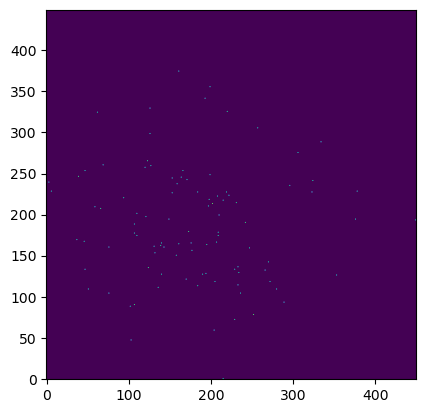

In [130]:
b = np.histogram2d(x_labels, y_labels, bins=(N, M))[0]
plt.imshow(b, origin='lower')

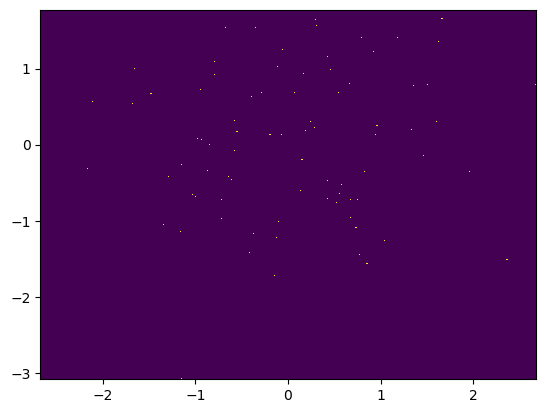

In [117]:
plt.hist2d(x_labels, y_labels, bins=(N, M));

In [34]:
data.shape

(100, 100)

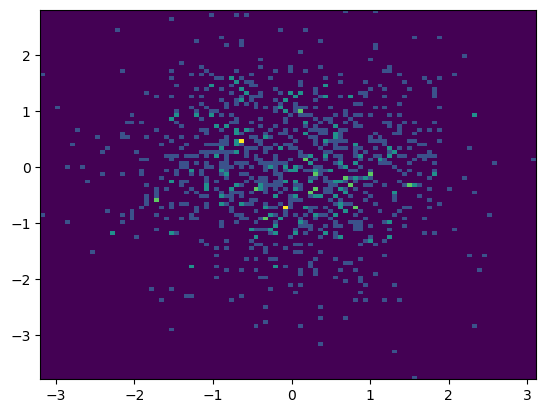

In [46]:
data = np.random.normal(0, 1, (2, 1000))
a = plt.hist2d(data[0], data[1], bins=100);
data = a[0]

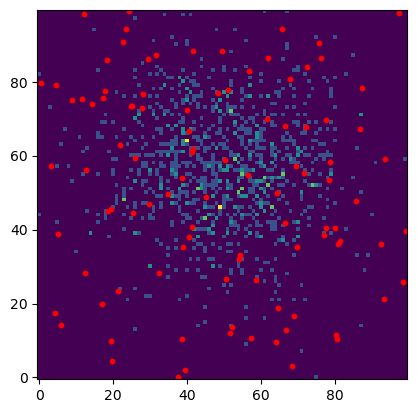

In [48]:
label = np.random.uniform(0, 100, (2, 100) )
plt.imshow(data.T, origin='lower', cmap='viridis')
plt.scatter(label[0], label[1], c='r', s=10)

In [105]:
crop_size = 50
crops = slidding_window(data, window_shape=(crop_size,crop_size))
print( crops.shape )

x_crops = data.shape[0] // crop_size
y_crops = data.shape[1] // crop_size
print( x_crops, y_crops )

(4, 50, 50)
2 2


In [87]:
x_label = label.astype(int)[0]
y_label = label.astype(int)[1]

In [98]:
height = data.shape[1] // crop_size

x_step = x_label // crop_size
y_step = y_label // crop_size

point_here = x_step * height + y_step

In [99]:
x_step

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1])

In [111]:
def labels_to_crops(data, labels, window_shape=(224, 224)):
    '''
    data: 2D array with the image (N, M)
    labels: 2D array with the labels (2, N)
    window_shape: shape of the window to crop the image
    '''

    data_shape = data.shape

    nb_windows_x = data_shape[0] // window_shape[0] # Number of windows in the x-axis
    nb_windows_y = data_shape[1] // window_shape[1] # Number of windows in the y-axis

    # Treat labels



    return 

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1])

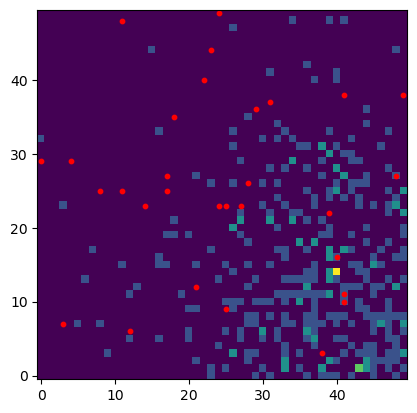

In [113]:
i = 1

plt.imshow(crops[i].T, origin='lower', cmap='viridis')

arg_in = np.where( point_here == i)
plt.scatter(x_label[arg_in] - crop_size*(i//y_crops), y_label[arg_in] - crop_size*(i%y_crops), c='r', s=10)